# Place Cell Analyses

Analyze TH data for place cells.

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment, compute_bin_time)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import (zscore_to_surrogates, compute_empirical_pvalue, 
                                           compute_surrogate_stats)
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pval
from spiketools.utils import restrict_range, get_value_by_time_range, set_random_seed
from spiketools.utils.trials import epoch_data_by_range, epoch_spikes_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing
from place import get_trial_place, compute_place_bins

In [5]:
from functools import partial
from spiketools.stats.anova import create_dataframe, fit_anova
create_df_place = partial(create_dataframe, columns=['bin', 'fr'])
fit_anova_place = partial(fit_anova, formula='fr ~ C(bin)', feature='C(bin)')

## Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [7]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [8]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [9]:
# Define bins to use
bins = [6, 10]
n_bins = bins[0] * bins[1]

# Define minimum required occupancy (in seconds)
min_occ = 1

In [10]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 10

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [11]:
# Set example unit to analyze
uind = 36

## Load Data

In [12]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [13]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Extract Time Definitions

In [14]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Position Data

In [15]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [16]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

#### Extract Boundaries

In [17]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [293.     424.3358]


#### Select position traces from navigation periods

In [18]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

In [19]:
# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

#### Extract Spike Data

In [20]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [21]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [22]:
# Compute position ranges
x_range, z_range = get_pos_ranges(positions)

In [23]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  365.40 - 404.59 (39.18)
Position Z-range:  302.87 - 411.54 (108.67)


In [24]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions, threshold=0.1)
spike_positions = np.array([spike_xs, spike_ys])

In [25]:
# Check binning
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins, area_range)

In [26]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 11.67, 13.13


### Occupancy

In [27]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

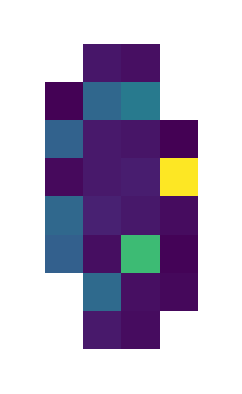

In [28]:
# Plot occupancy
plot_heatmap(occ, transpose=True, ignore_zero=False, figsize=(5, 7))

## Check spike locations

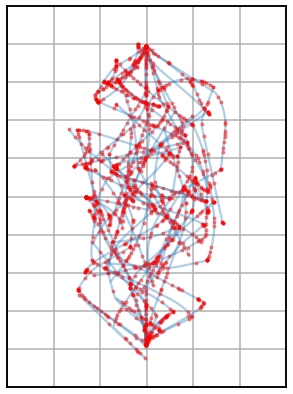

In [29]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [30]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [31]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

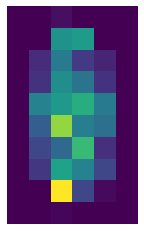

In [32]:
# Check the firing map
plot_heatmap(bin_firing, transpose=True)

In [33]:
# Normalize bin firing by occupancy
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
normed_bin_firing = bin_firing / occ

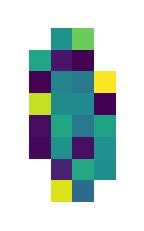

In [34]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, transpose=True)

## Place coding per trial

In [35]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

# Set a trial index to get data for
t_ind = 5

Number of trials: 24


In [36]:
# Get the navigation time ranges
nav_starts_trial = nwbfile.trials.navigation_start[t_ind]
nav_stops_trial = nwbfile.trials.navigation_stop[t_ind]

In [37]:
# Get data for selected trial: trial positions, spikes, and spike positions
trial_times, trial_pos = get_value_by_time_range(ptimes, positions,
                                                 nav_starts_trial, nav_stops_trial)
trial_spikes = restrict_range(spikes, nav_starts_trial, nav_stops_trial)
trial_spike_pos_x, trial_spike_pos_y = get_spike_positions(trial_spikes, trial_times, trial_pos)
spike_positions_trial = np.array([trial_spike_pos_x, trial_spike_pos_y])

In [38]:
# Compute spatial bin assignments for each spike
x_binl_trial, y_binl_trial = compute_spatial_bin_assignment(spike_positions_trial, x_bin_edges, y_bin_edges)

In [39]:
# Compute summary map of bin firing for one selected trial
bin_firing_trial = (compute_bin_firing(x_binl_trial, y_binl_trial, bins)).flatten()

# ANOVA TEST

### Use fr ~ C(bin),  real data

In [45]:
# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ, 'area_range' : area_range, 'set_nan' : True}

In [46]:
# Collect place firing, organized per trial
place_trial = get_trial_place(spikes, nwbfile.trials, bins, ptimes, positions,
                              speed, x_bin_edges, y_bin_edges, occ_kwargs)

In [47]:
# Create the dataframe
df = create_df_place(place_trial, drop_na=True)

In [49]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_place(df)
f_val

2.4564650097039515

# ANOVA Surrogate

### fr ~ C(bin), 100 surrogates

In [50]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [54]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    
    place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
                                 speed, x_bin_edges, y_bin_edges, occ_kwargs)
    df = create_df_place(place_trial)
    surrogates[ind] = fit_anova_place(df)

p-value: 0.60
z-score: -0.27


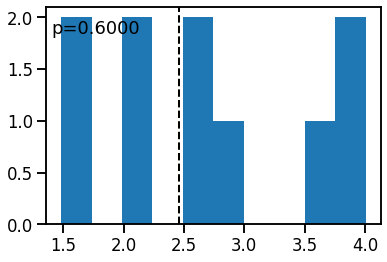

In [55]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

## All Cells

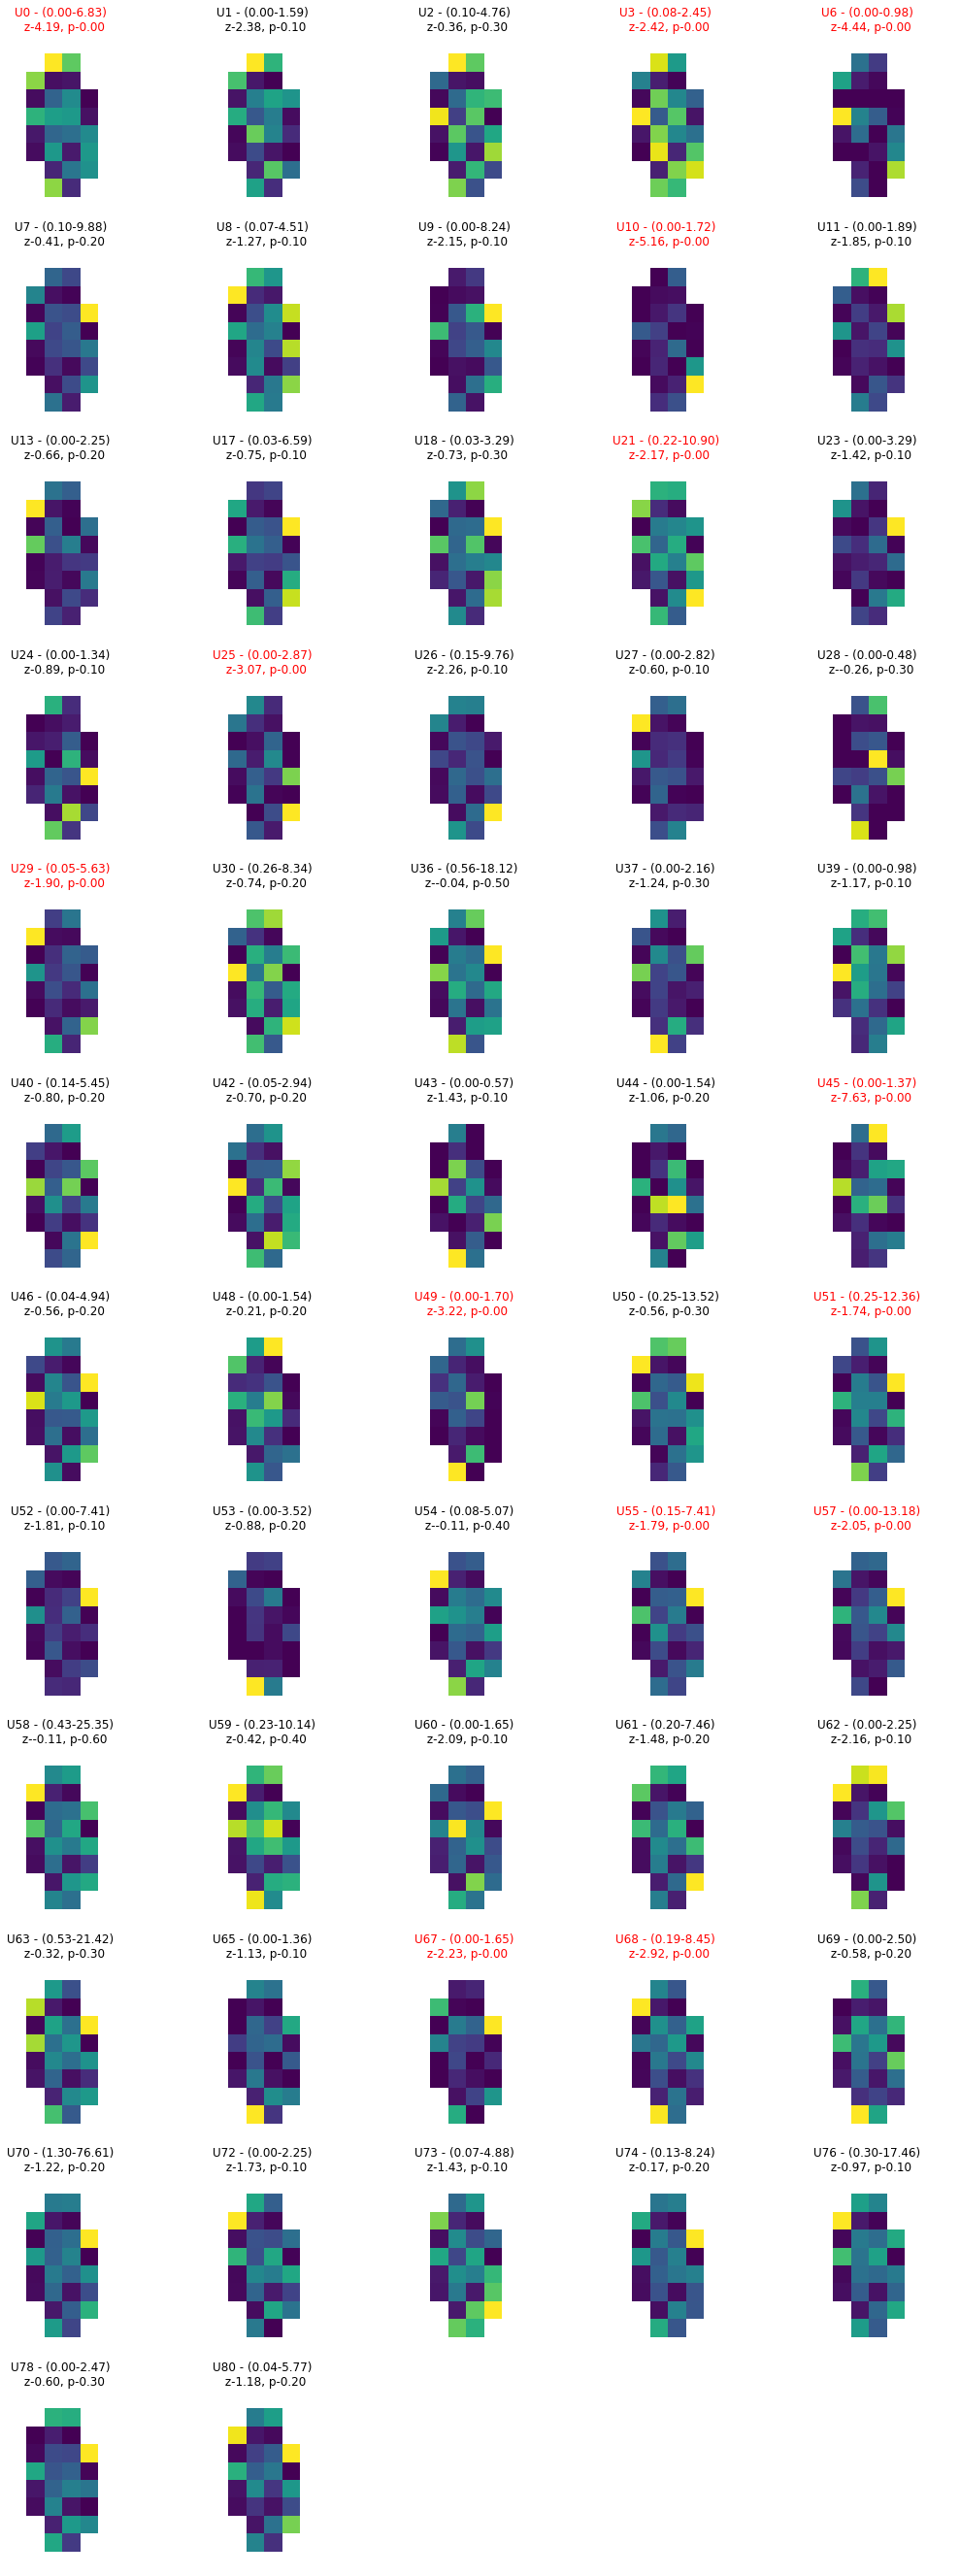

In [60]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
    
    surrogates = np.zeros(n_surrogates)
    for ind, shuffle in enumerate(times_shuffle):
        place_trial = get_trial_place(shuffle, nwbfile.trials, bins, ptimes, positions,
                                      speed, x_bin_edges, y_bin_edges, occ_kwargs)
        df = create_df_place(place_trial)
        surrogates[ind] = fit_anova_place(df)
        
    p_val, z_score = compute_surrogate_stats(f_val, surrogates, plot=False, verbose=False, ax=ax)

    bin_firing = compute_place_bins(spikes, bins, ptimes, positions, speed,
                                    x_bin_edges, y_bin_edges, **occ_kwargs)
    minb, maxb = np.nanmin(bin_firing), np.nanmax(bin_firing)
    plot_heatmap(bin_firing, transpose=True, ax=ax)
    ax.set_title('U{} - ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(ii, minb, maxb, z_score, p_val),
                 fontdict={'fontsize' : 12}, color=color_pval(p_val))